In [12]:
!pip install tsfel
!pip install pandas
!pip install numpy
!pip install sci-kit learn
!pip install matplotlib
!pip install tsfel
import pandas as pd
import numpy as np
import tsfel
from itertools import product
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement sci-kit (from versions: none)
ERROR: No matching distribution found for sci-kit

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
X_train = np.array(np.load("../X_train.npy"))
X_test = np.array(np.load("../X_test.npy"))
Y_train = np.array(np.load("../Y_train.npy"))
Y_test = np.array(np.load("../Y_test.npy"))
cfg = tsfel.get_features_by_domain()
feature_df = tsfel.time_series_features_extractor(cfg, X_train, verbose = 0, fs = 50)
feature_df_test = tsfel.time_series_features_extractor(cfg, X_test, verbose = 0, fs = 50)

In [6]:
def decision_tree_training(dataframeX,dataframeY,depth = None,random_state= 2):
    clf = tree.DecisionTreeClassifier(max_depth = depth,random_state=random_state)
    clf = clf.fit(dataframeX, dataframeY)
    return clf

def metrics(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    precision = precision_score(y_test, y_pred,average='weighted')
    print(f"Precision: {precision}")

    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall: {recall}")

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

def decision_Tree_predict(clf,test_data_x):
    y_pred = clf.predict(test_data_x)
    y_pred = np.array(y_pred)
    return y_pred


def decision_Tree_plot(clf,y_pred,y_test,features):
    
    plt.figure(figsize=(20, 10))
    tree.plot_tree(clf, filled=True, feature_names=features)
    plt.title('Decision Tree Visualization')
    plt.show()
    metrics(y_pred,y_test)

In [7]:
def decision_tree_raw(depth):
    X_test = np.array(np.load('../X_test.npy'))
    X_train = np.array(np.load('../X_train.npy'))
    y_test = np.array(np.load('../y_test.npy'))
    y_train = np.array(np.load('../y_train.npy'))
    accx = []
    accy =[]
    accz = []
    output = []

    for i in range(len(X_train)):
        for j in X_train[i]:
            accx.append(j[0])
            accy.append(j[1])
            accz.append(j[2])
            output.append(y_train[i])
    
    flattened_X_train = []

    for sample in X_train:
        for item in sample:
            flattened_X_train.append(item)

    flattened_X_test = []

    for sample in X_test:
        for item in sample:
            flattened_X_test.append(item)

    Xtrain_dataframe = pd.DataFrame(flattened_X_train, columns=['accx', 'accy', 'accz'])
    Xtest_dataframe = pd.DataFrame(flattened_X_test, columns=['accx', 'accy', 'accz'])
    ytrainout = pd.Series(np.repeat(y_train, 500))
    clf = decision_tree_training(Xtrain_dataframe,ytrainout,depth)

    y_pred = decision_Tree_predict(clf,Xtest_dataframe)
    y_pred = np.array(y_pred)  
    num_rows = int(len(y_pred)/500)
    y_pred_reshaped = y_pred.reshape(num_rows, 500)
    modes = []
    for row in y_pred_reshaped:
        mode = pd.Series(row).mode()
        modes.append(mode.iloc[0])
    aggr_y_pred = np.array(modes)
    decision_Tree_plot(clf,aggr_y_pred,y_test,['Acceleration X','Acceleration Y','Acceleration Z'])

In [8]:
def decision_tree_features(depth = None):
    feature_labels = pd.read_csv(r'../HAR/UCI HAR Dataset/features.txt',sep = '\\s+',header=None)
    dataframeX = pd.read_csv(r'../HAR/UCI HAR Dataset/train/X_train.txt',sep = '\\s+',header=None)
    dataframeY = pd.read_csv(r'../HAR/UCI HAR Dataset/train/y_train.txt',sep = '\\s+',header=None)
    test_values_y = pd.read_csv(r'../HAR/UCI HAR Dataset/test/y_test.txt',sep = "\\s+",header=None)
    test_data_X = pd.read_csv(r'../HAR/UCI HAR Dataset/test/X_test.txt',sep = "\\s+",header=None)
    correlation_matrix = dataframeX.corr()
    threshold = 0.98
    removals = []

    pairs = product(range(len(correlation_matrix.columns)), repeat=2)

    for i, j in pairs:
        if i > j:
            correlation_value = correlation_matrix.iloc[i, j]
            if abs(correlation_value) > threshold and correlation_value != 1:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                if colname_i not in removals and colname_j not in removals:
                    removals.append(colname_i)

    selected_features = [col for col in dataframeX.columns if col not in removals]
    filtered_dfX = dataframeX[selected_features]
    features = []
    for i in selected_features:
        features.append(feature_labels[1][i])

    
    clf = decision_tree_training(filtered_dfX,dataframeY,depth)
    
    filtered_testx =test_data_X[selected_features]
    y_test = test_values_y[0].to_numpy()
    y_pred = decision_Tree_predict(clf,filtered_testx)
    decision_Tree_plot(clf,y_pred,y_test,features) 

In [10]:
def decision_tree_TSFEL(depth = None):
    clf =decision_tree_training(feature_df,Y_train,depth)
    y_pred = decision_Tree_predict(clf,feature_df_test)
    decision_Tree_plot(clf,y_pred,Y_test,feature_df_test.columns)  

In [33]:
# X_test = np.array(np.load('../X_test.npy'))
# X_train = np.array(np.load('../X_train.npy'))
# y_test = np.array(np.load('../y_test.npy'))
# y_train = np.array(np.load('../y_train.npy'))
# accx = []
# accy =[]
# accz = []
# output = []

# for i in range(len(X_train)):
#     for j in X_train[i]:
#         accx.append(j[0])
#         accy.append(j[1])
#         accz.append(j[2])
#         output.append(y_train[i])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(df['accx'], df['accy'], df['accz'], c='r', marker='o')

# ax.set_xlabel('accx')
# ax.set_ylabel('accy')
# ax.set_zlabel('accz')

# plt.show()

Tree of Depth : 2


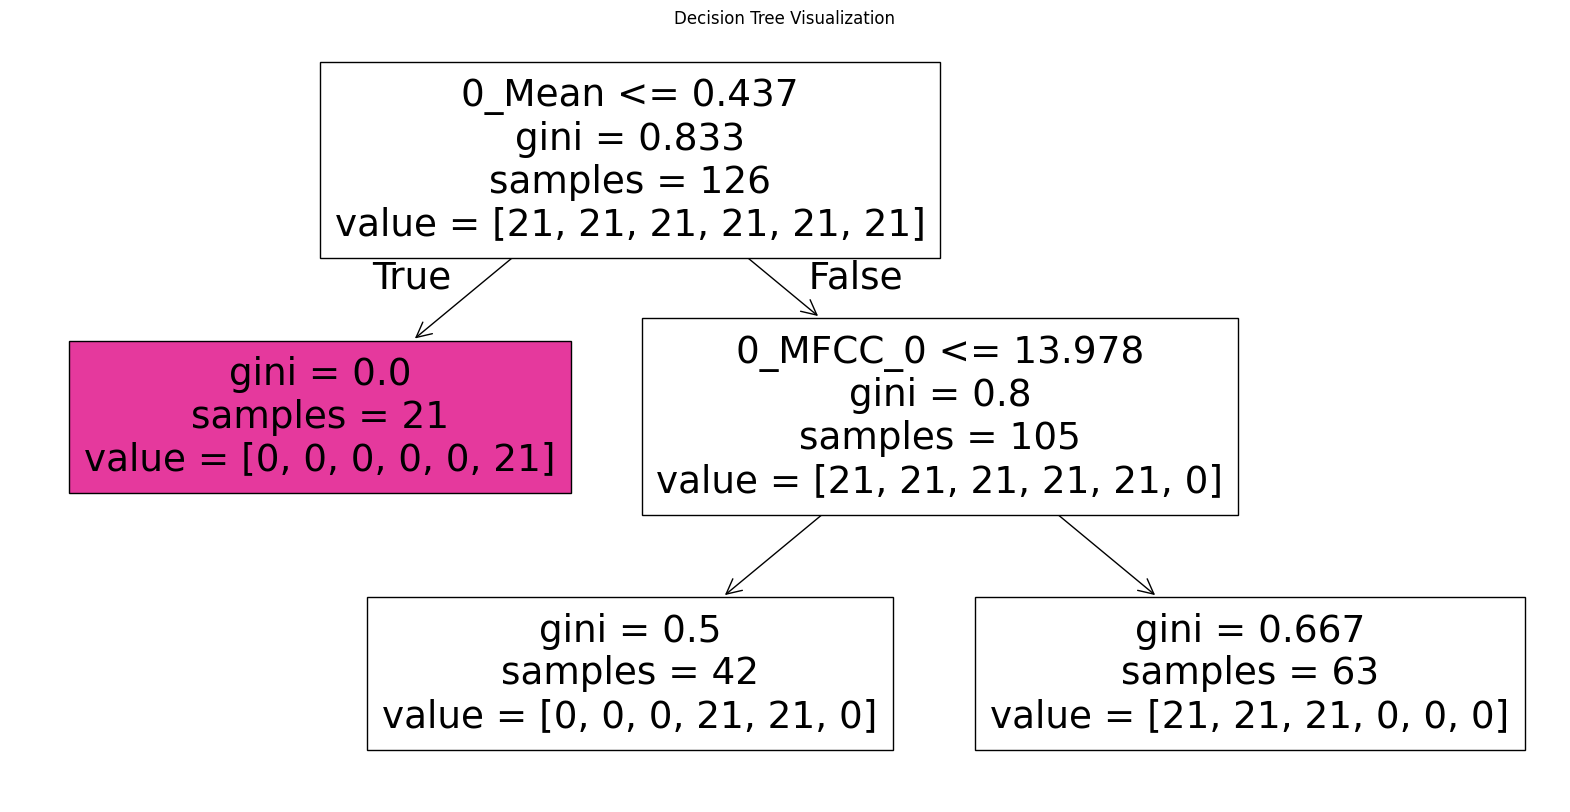

Accuracy: 0.5
Precision: 0.3055555555555556
Recall: 0.5
Confusion Matrix:
[[9 0 0 0 0 0]
 [9 0 0 0 0 0]
 [9 0 0 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 0 9]]
Tree of Depth : 3


c:\Users\skabh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


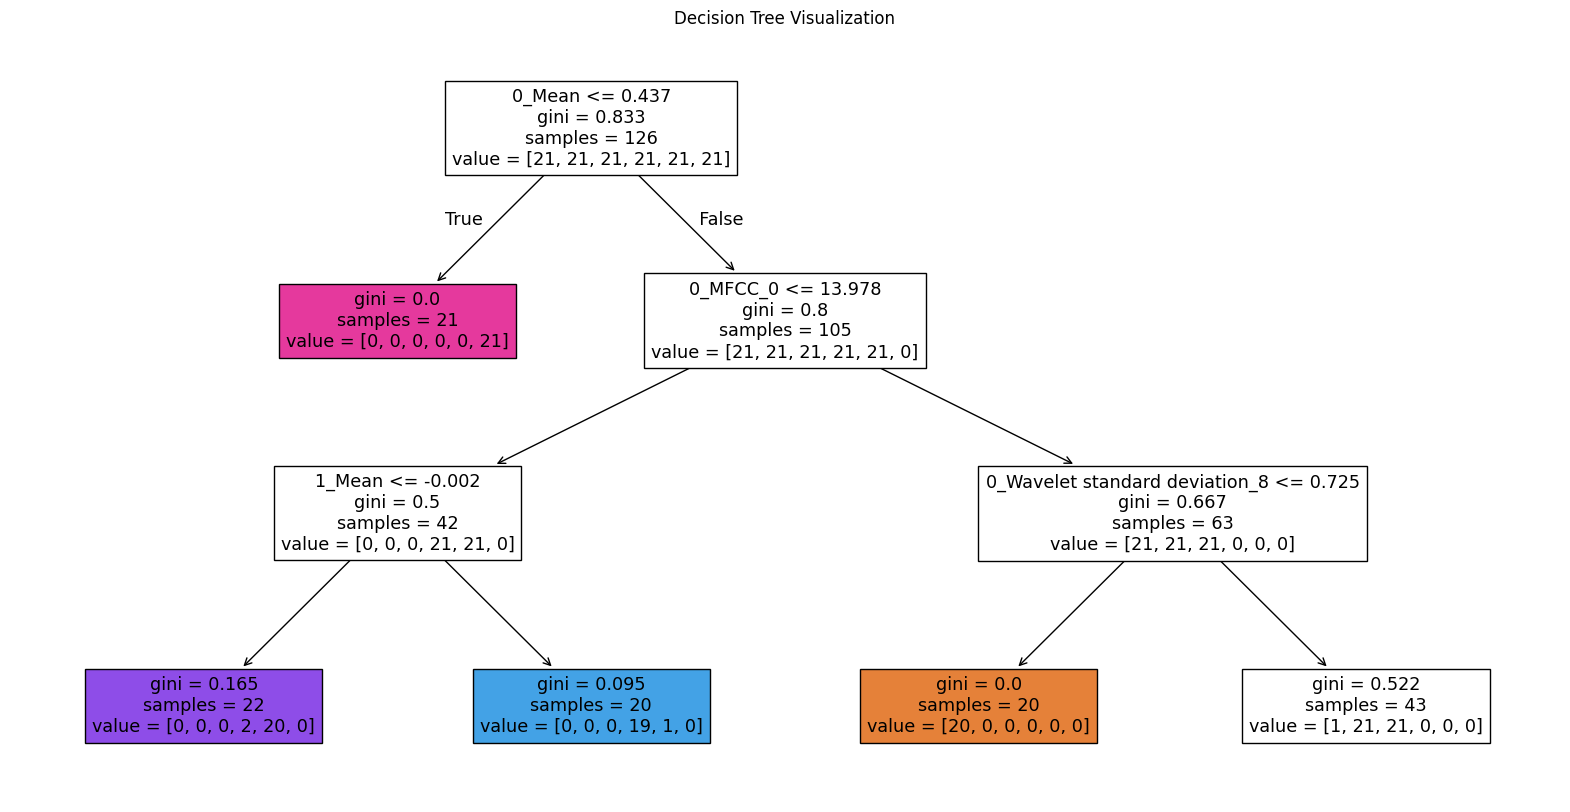

Accuracy: 0.7592592592592593
Precision: 0.7095238095238096
Recall: 0.7592592592592593
Confusion Matrix:
[[6 3 0 0 0 0]
 [1 8 0 0 0 0]
 [0 9 0 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]
Tree of Depth : 4


c:\Users\skabh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


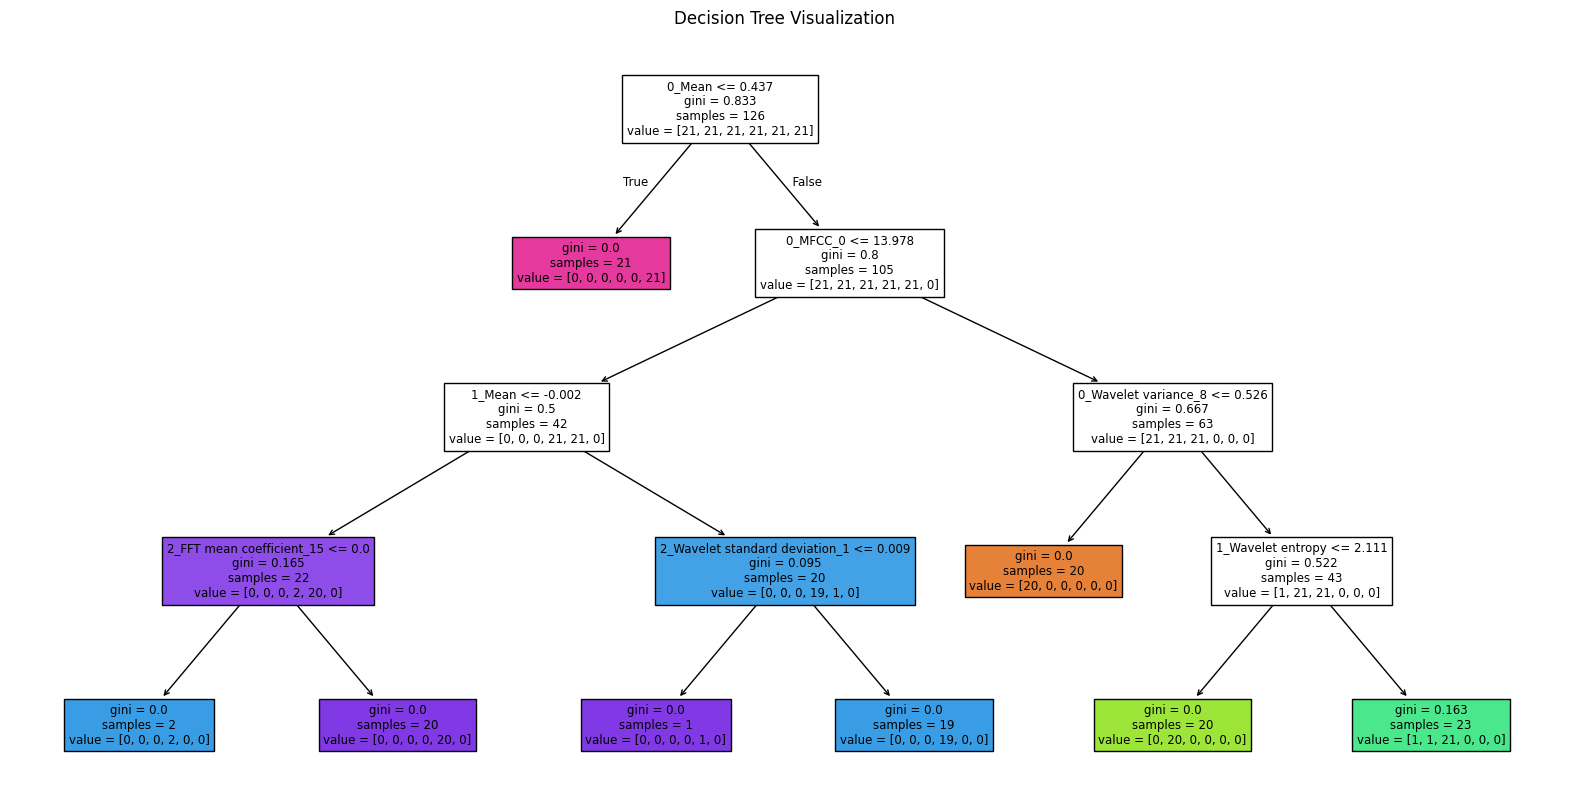

Accuracy: 0.8888888888888888
Precision: 0.8936988936988937
Recall: 0.8888888888888888
Confusion Matrix:
[[6 1 2 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]
Tree of Depth : 5


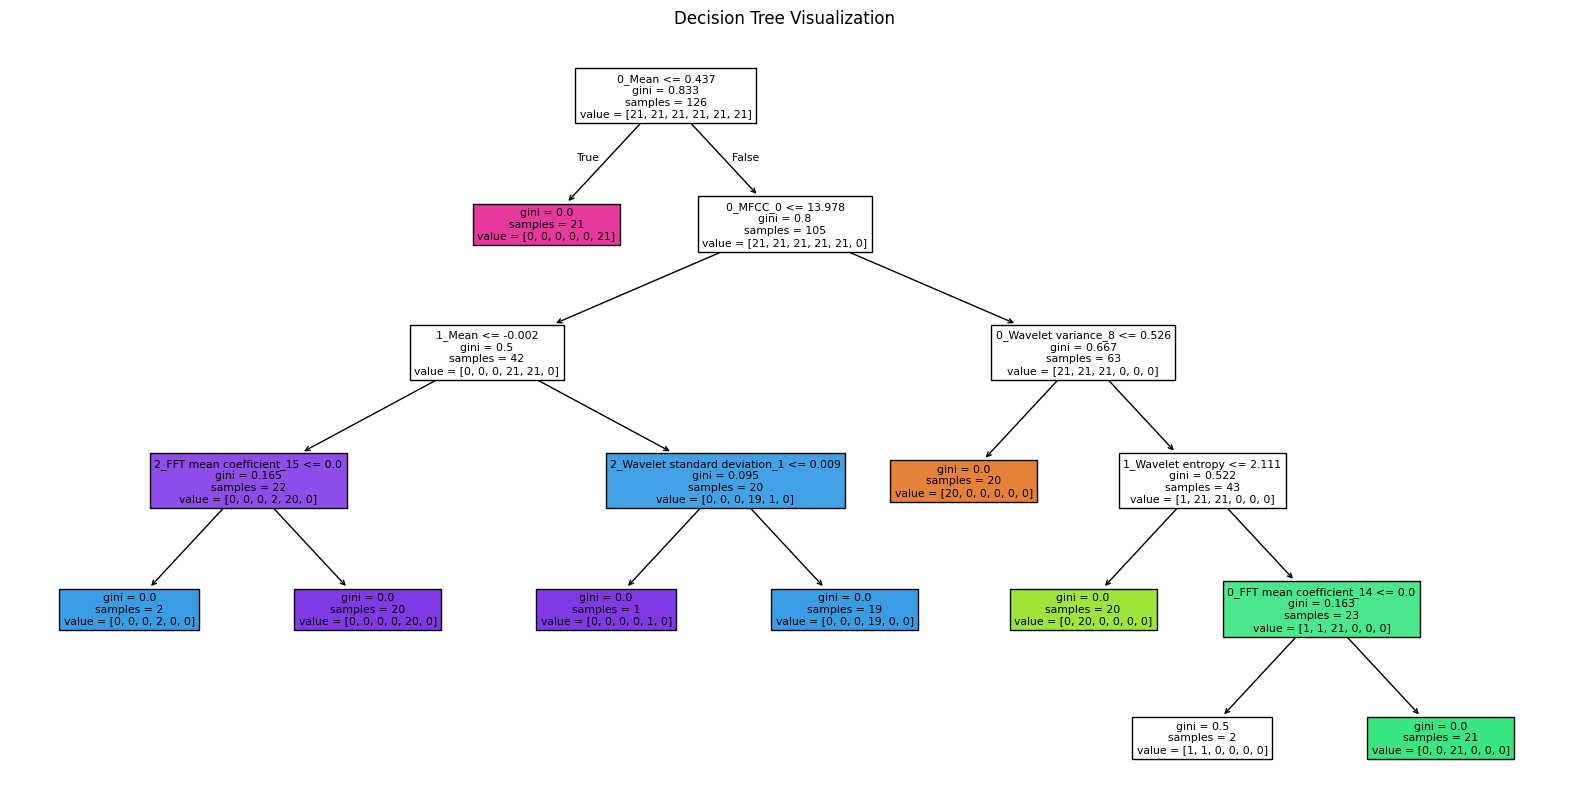

Accuracy: 0.8888888888888888
Precision: 0.8936988936988937
Recall: 0.8888888888888888
Confusion Matrix:
[[6 1 2 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]
Tree of Depth : 6


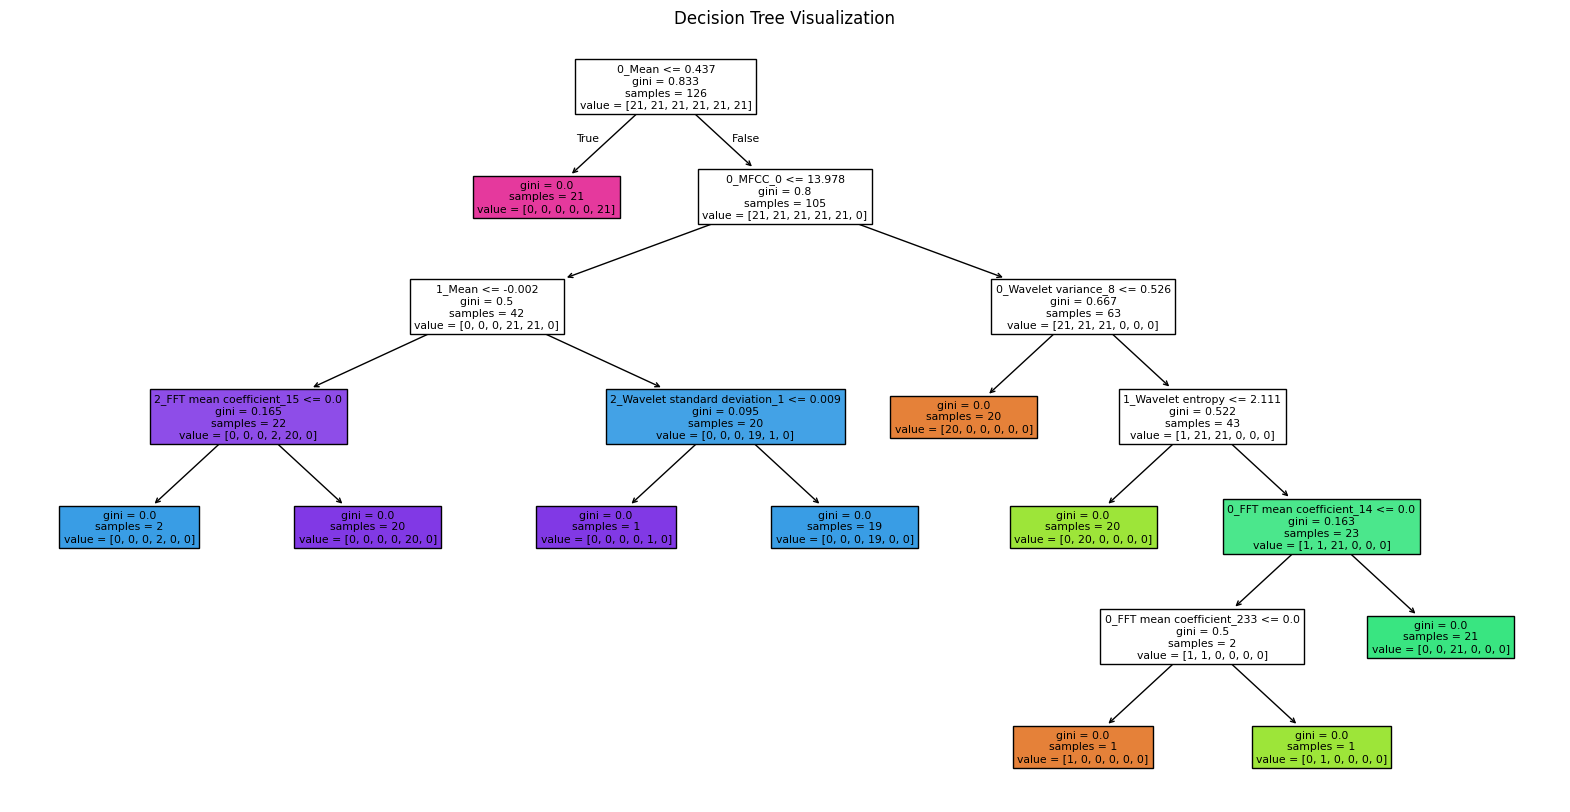

Accuracy: 0.8888888888888888
Precision: 0.8936988936988937
Recall: 0.8888888888888888
Confusion Matrix:
[[6 1 2 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]
Tree of Depth : 7


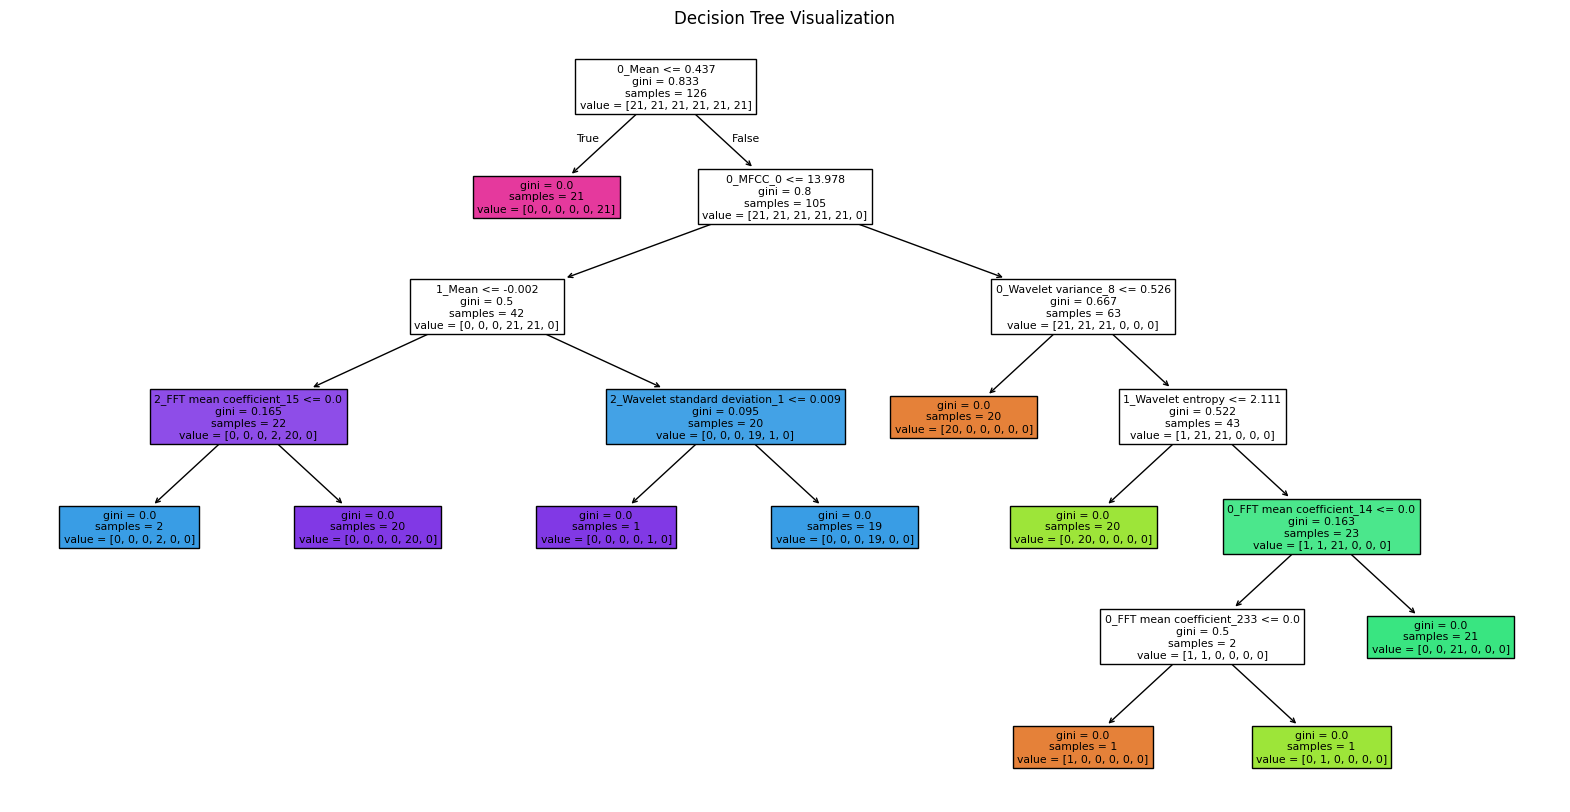

Accuracy: 0.8888888888888888
Precision: 0.8936988936988937
Recall: 0.8888888888888888
Confusion Matrix:
[[6 1 2 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]
Tree of Depth : 8


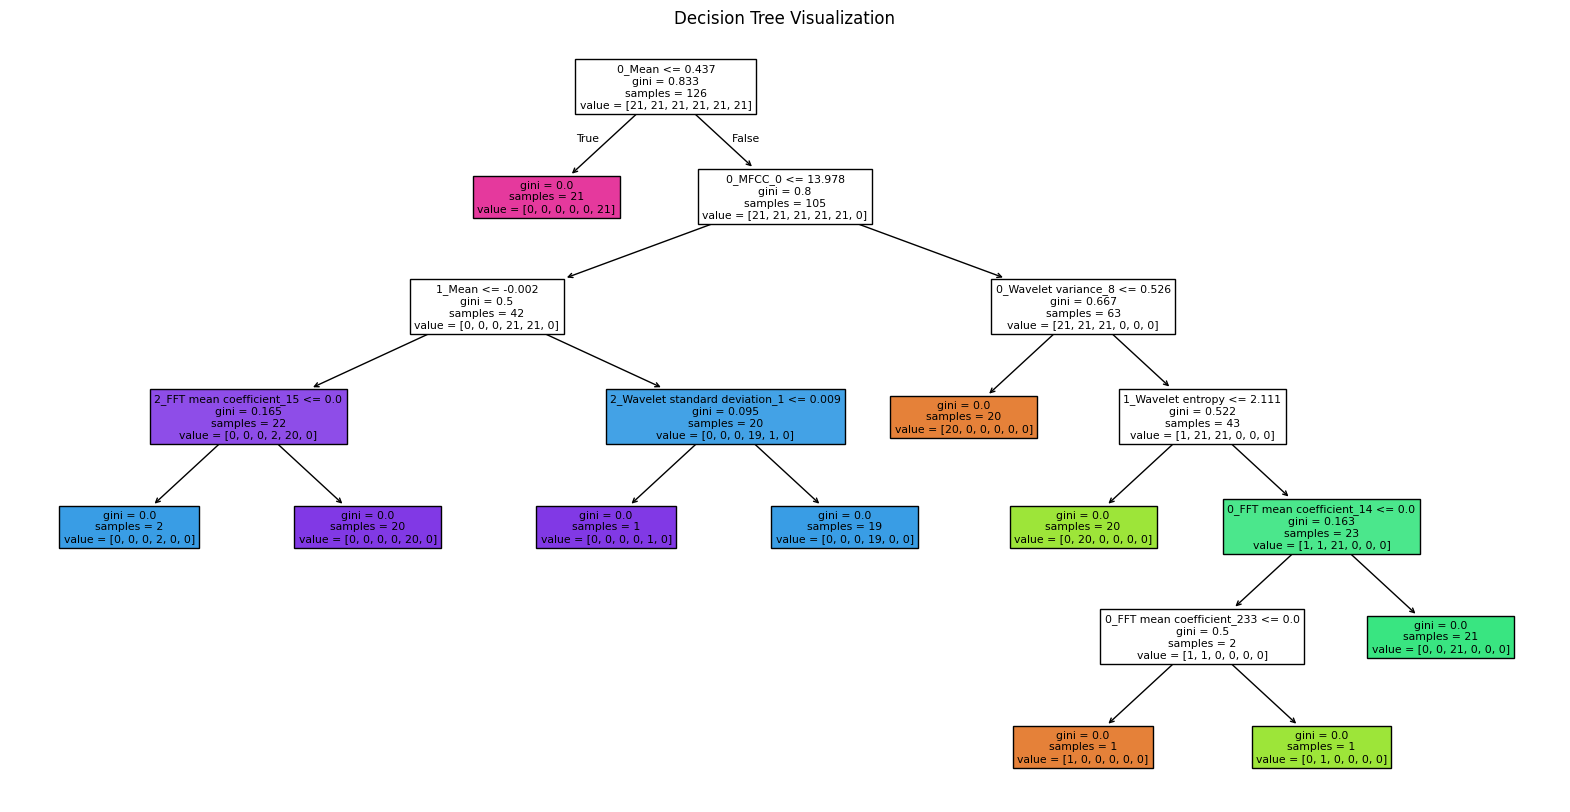

Accuracy: 0.8888888888888888
Precision: 0.8936988936988937
Recall: 0.8888888888888888
Confusion Matrix:
[[6 1 2 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]


In [13]:
for i in range(2,9):
    print("Tree of Depth :",i)
    decision_tree_TSFEL(depth = i)

Tree of Depth : 2
           accx      accy      accz
0      1.196480 -0.160690 -0.740178
1      1.222030 -0.267295 -0.771748
2      1.223110 -0.433863 -0.767842
3      1.119198 -0.533790 -0.756309
4      0.915843 -0.496126 -0.629135
...         ...       ...       ...
62995  0.834664 -0.084789 -0.402108
62996  0.741997 -0.107038 -0.368874
62997  0.652846 -0.106747 -0.345863
62998  0.640395 -0.106293 -0.339603
62999  0.635090 -0.096517 -0.327336

[63000 rows x 3 columns]
           accx      accy      accz
0      1.293474 -0.314044 -0.248005
1      1.258798 -0.290903 -0.513713
2      1.258902 -0.345183 -0.505633
3      1.235350 -0.396729 -0.239465
4      1.259212 -0.418217 -0.006383
...         ...       ...       ...
26995  0.929636  0.192764  0.369441
26996  0.927869  0.191753  0.369351
26997  0.926002  0.192286  0.366709
26998  0.925441  0.192937  0.362487
26999  0.928037  0.194660  0.370403

[27000 rows x 3 columns]


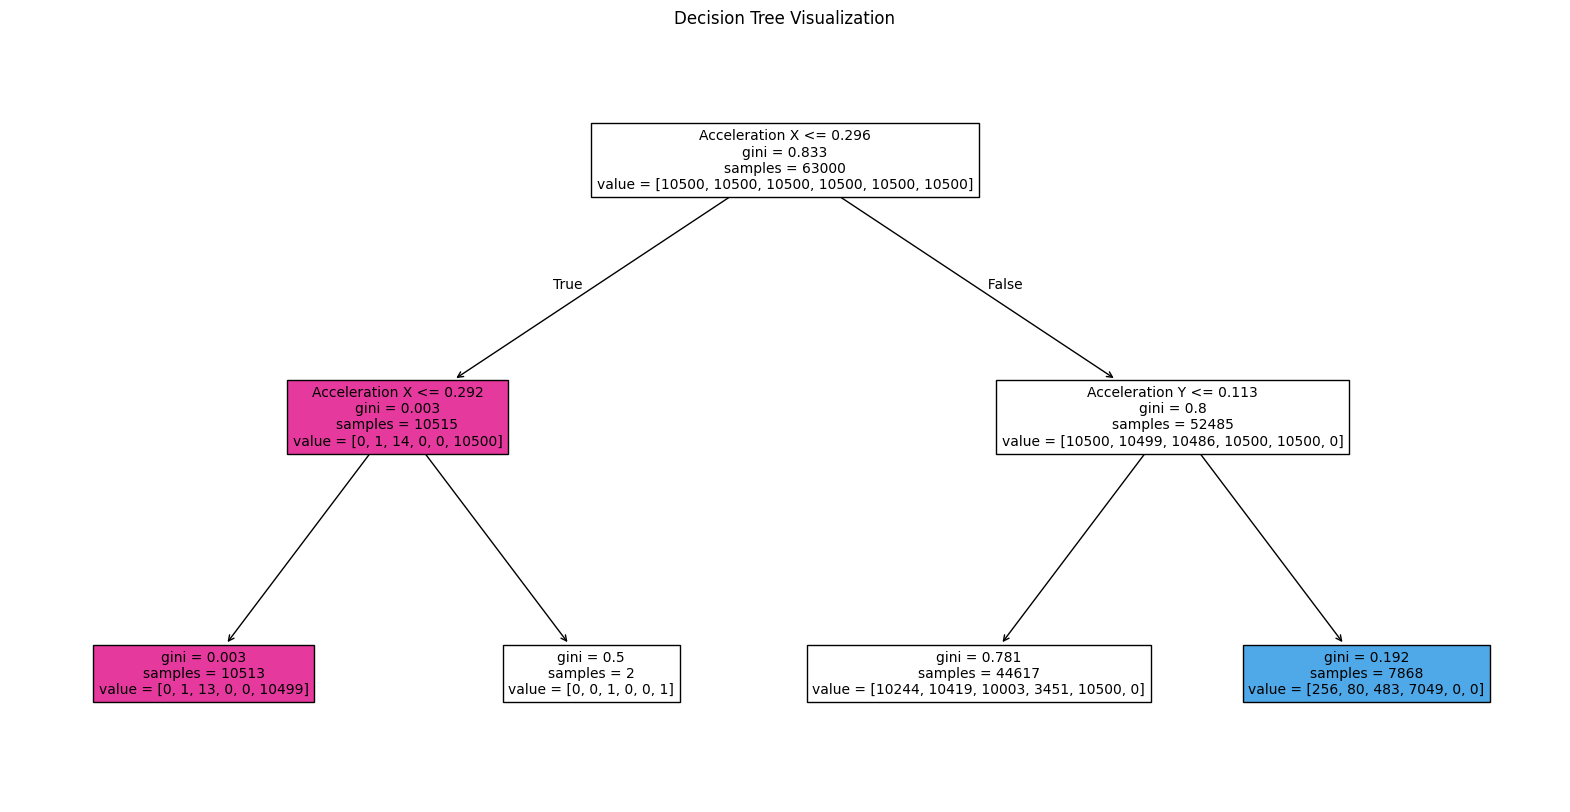

Accuracy: 0.48148148148148145
Precision: 0.3738738738738739
Recall: 0.48148148148148145
Confusion Matrix:
[[0 0 0 0 9 0]
 [0 0 0 0 9 0]
 [0 0 0 0 9 0]
 [0 0 0 8 1 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]


c:\Users\Arjun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
for i in range(2,3):
    print("Tree of Depth :",i)
    decision_tree_raw(depth = i)

In [ ]:
decision_tree_raw()

0        2
1        2
2        2
3        2
4        2
        ..
62995    2
62996    2
62997    2
62998    2
62999    2
Length: 63000, dtype: int64


Tree of Depth : 2


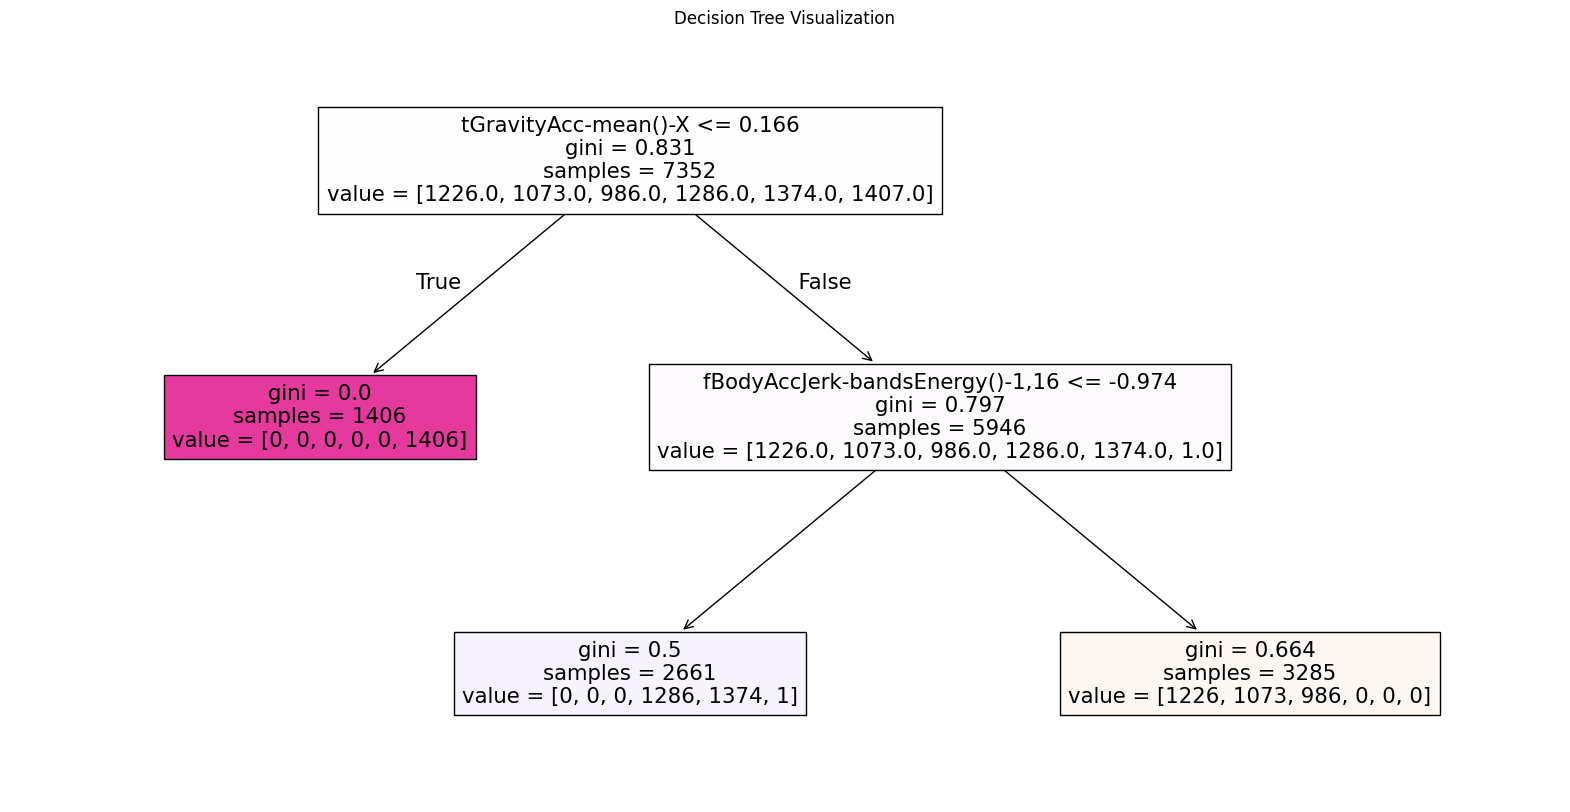

Tree of Depth : 3


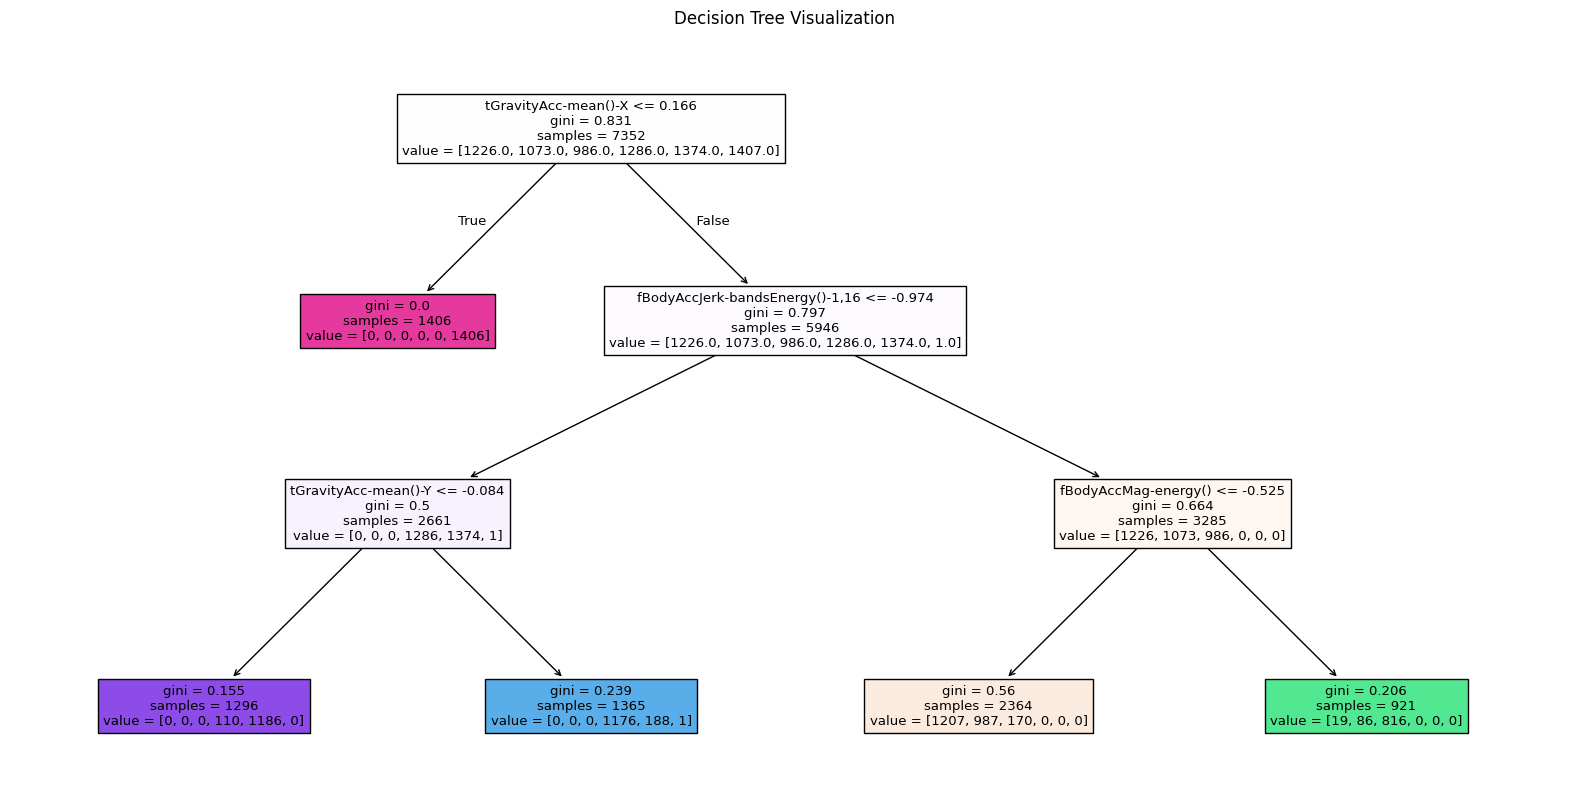

Tree of Depth : 4


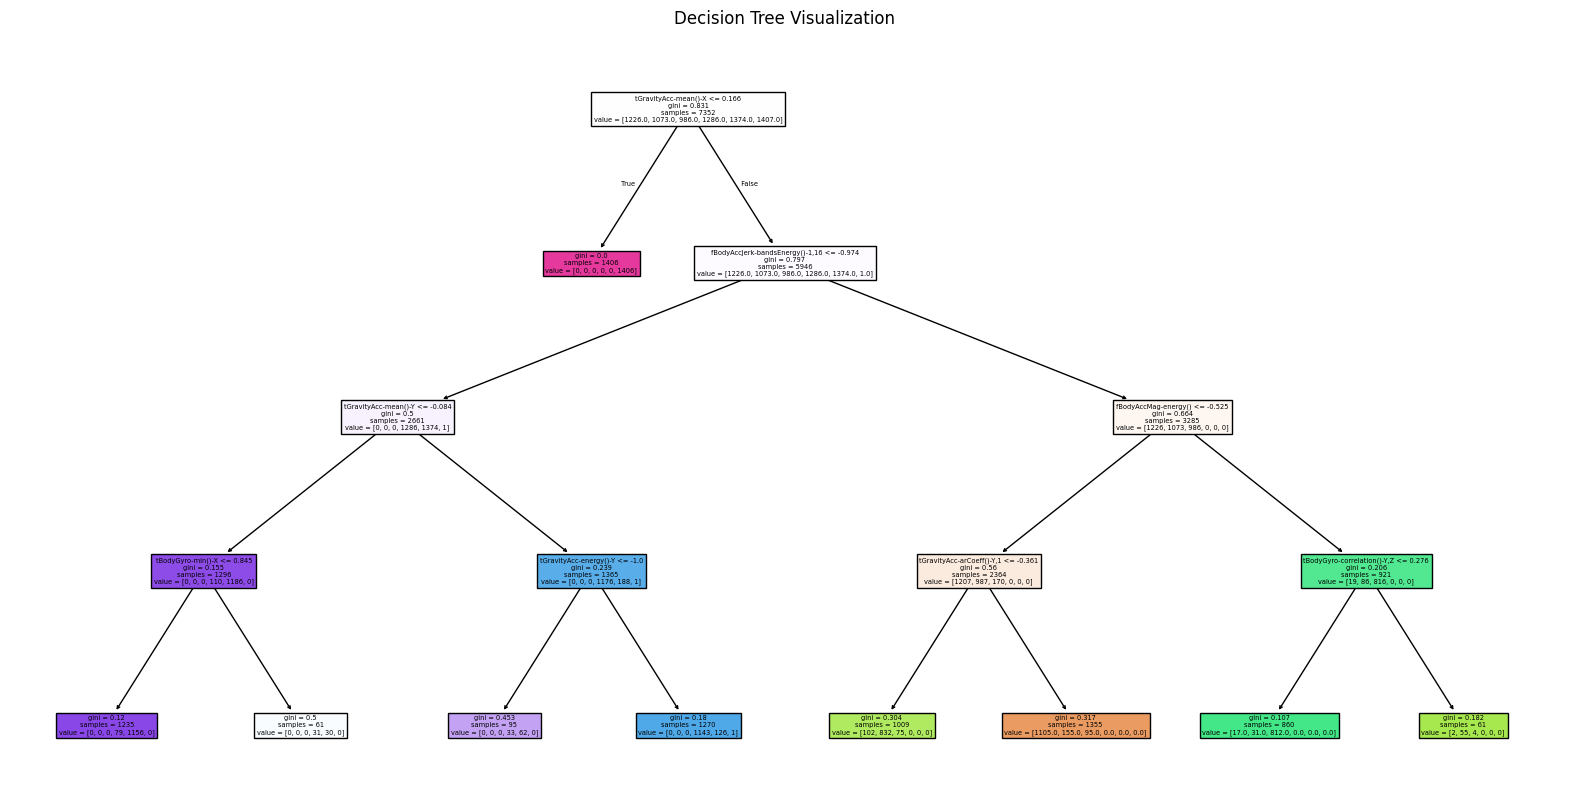

Tree of Depth : 5


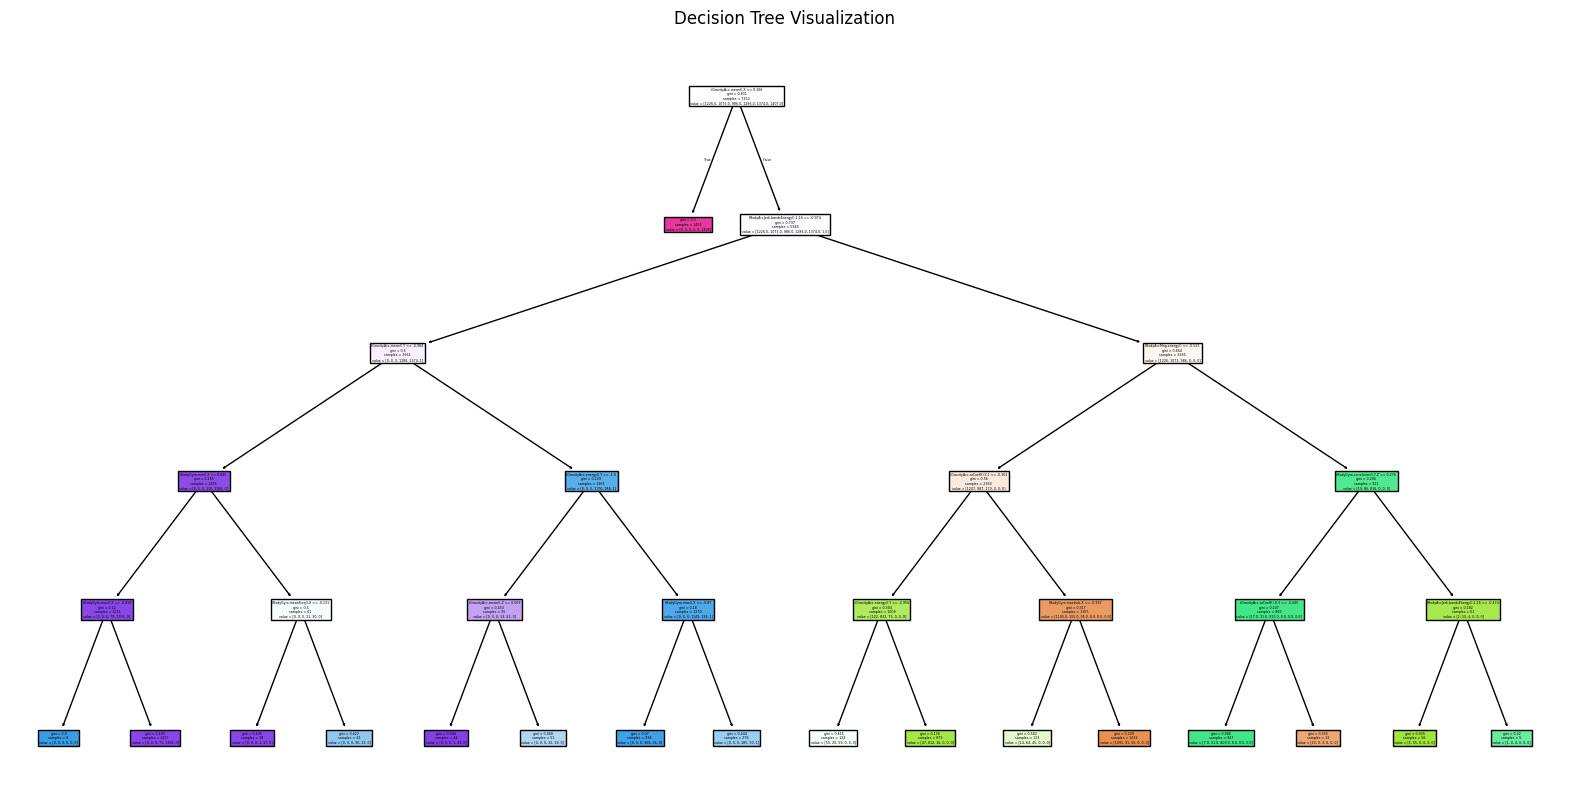

Tree of Depth : 6


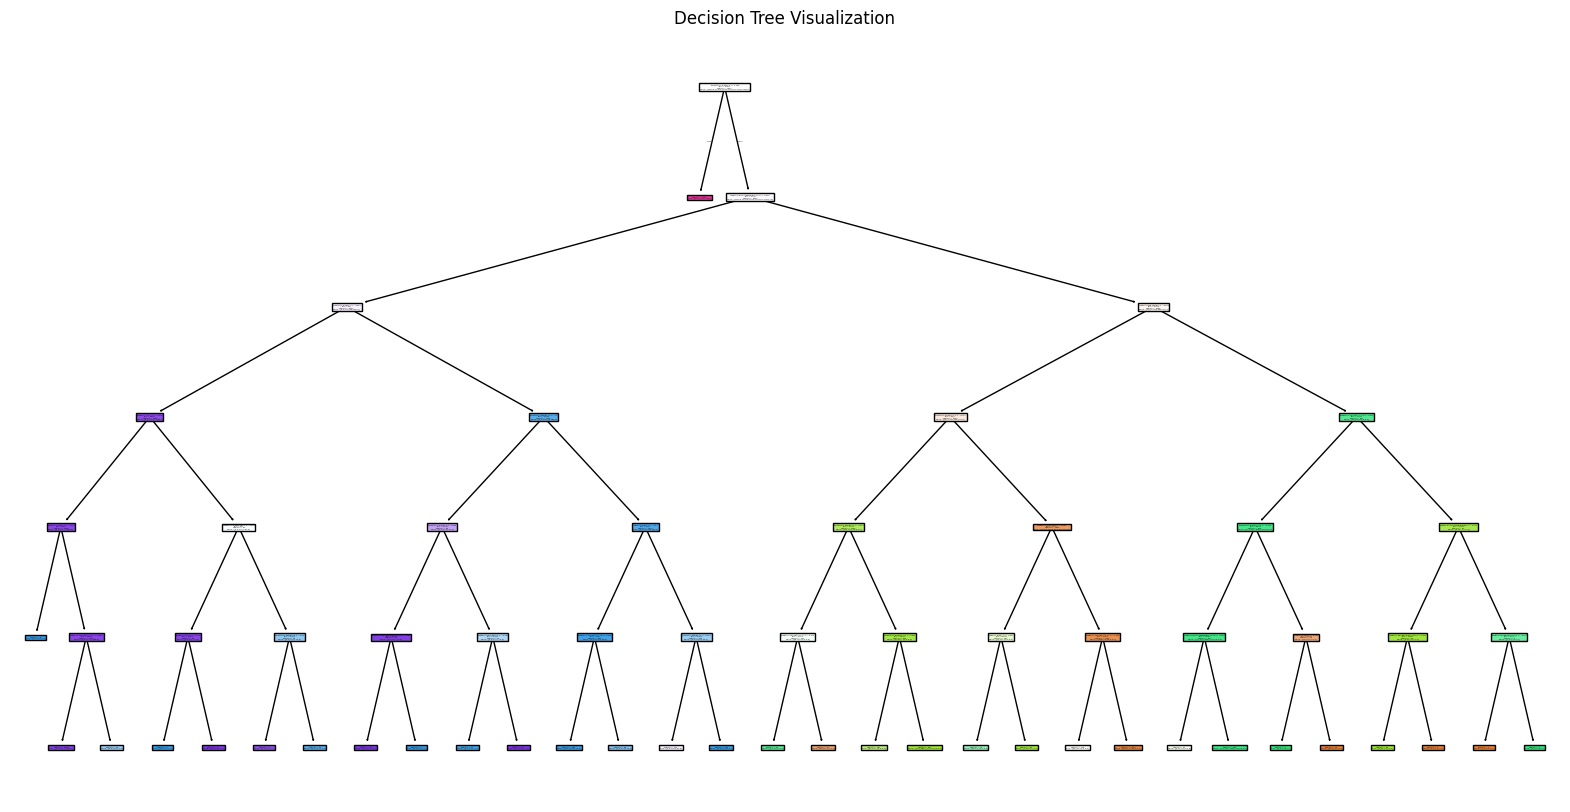

Tree of Depth : 7


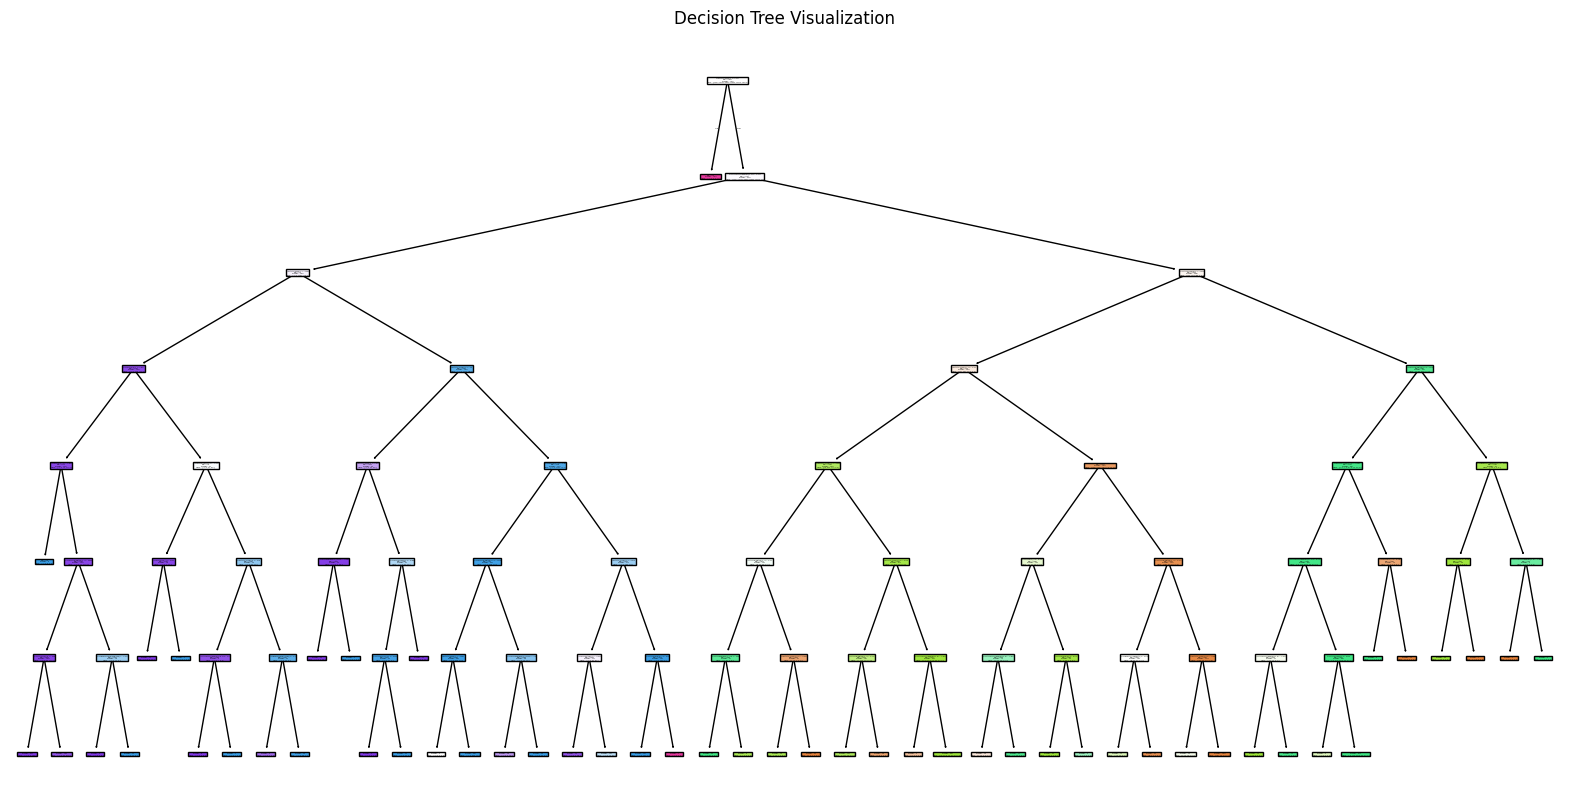

Tree of Depth : 8


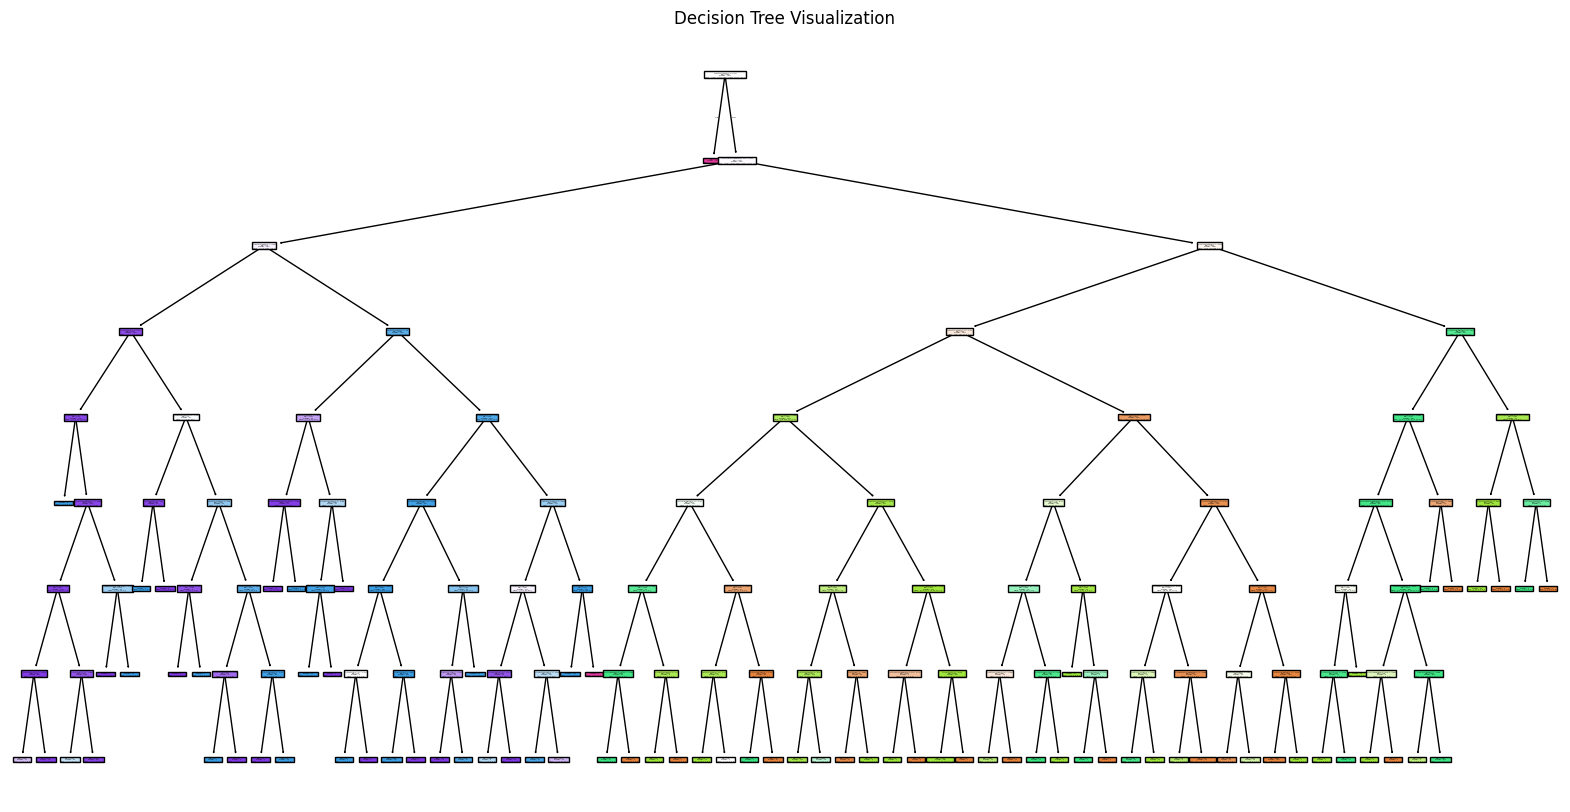

In [ ]:
for i in range(2,9):
    print("Tree of Depth :",i)
    decision_tree_features(depth = i)